In [1]:
import pandas as pd 
import os
import time
import csv
import itertools
import collections
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

import copy as cp
import numpy as np 
from numpy.fft import fft, ifft
from typing import Tuple

import scipy
from scipy import stats
from sklearn import preprocessing, svm
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn.utils import resample
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

import tsfresh as tf
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.feature_extraction import extract_features, MinimalFCParameters
from tsfresh.feature_extraction import ComprehensiveFCParameters

import keras
import tensorflow as tsf
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout, Input, BatchNormalization, Activation, Embedding, Add, LSTM, SimpleRNN
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint


plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['font.size'] = (20)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

In [2]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.RdYlBu):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'], linewidth=8, c='black')
    plt.plot(history.history['val_accuracy'], linewidth=8, c='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'], linewidth=8, c='black')
    plt.plot(history.history['val_loss'], linewidth=8, c='red')
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [3]:
path = './mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

# read files
filenames = next(os.walk(path))[2]

records = list()
annotations = list()
filenames.sort()

# segregating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)
        
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
        
            # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ') #The split() method splits a string into a list.
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
           # if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
                #    pass
            #else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    
                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

X_df = pd.DataFrame(X)
#converting uV to mV

print('This is what the df looks like, where 0-359 is the time in ms and row # is the sample number')
X_df.head()

This is what the df looks like, where 0-359 is the time in ms and row # is the sample number


,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
0,957,956,961,964,964,966,965,966,967,969,...,957,958,958,955,955,955,960,958,957,0
1,950,951,952,951,956,959,961,960,958,958,...,948,950,952,951,952,951,948,950,951,0
2,946,949,952,956,957,958,957,957,959,960,...,957,957,958,957,956,957,960,956,956,0
3,960,961,960,959,961,965,967,964,965,967,...,956,958,960,961,959,957,953,955,956,0
4,939,940,943,948,950,951,951,951,955,958,...,962,962,962,958,957,958,960,959,959,0


In [10]:
X_df = pd.DataFrame(X)

Text(0, 0.5, 'Amplitude (mV)')

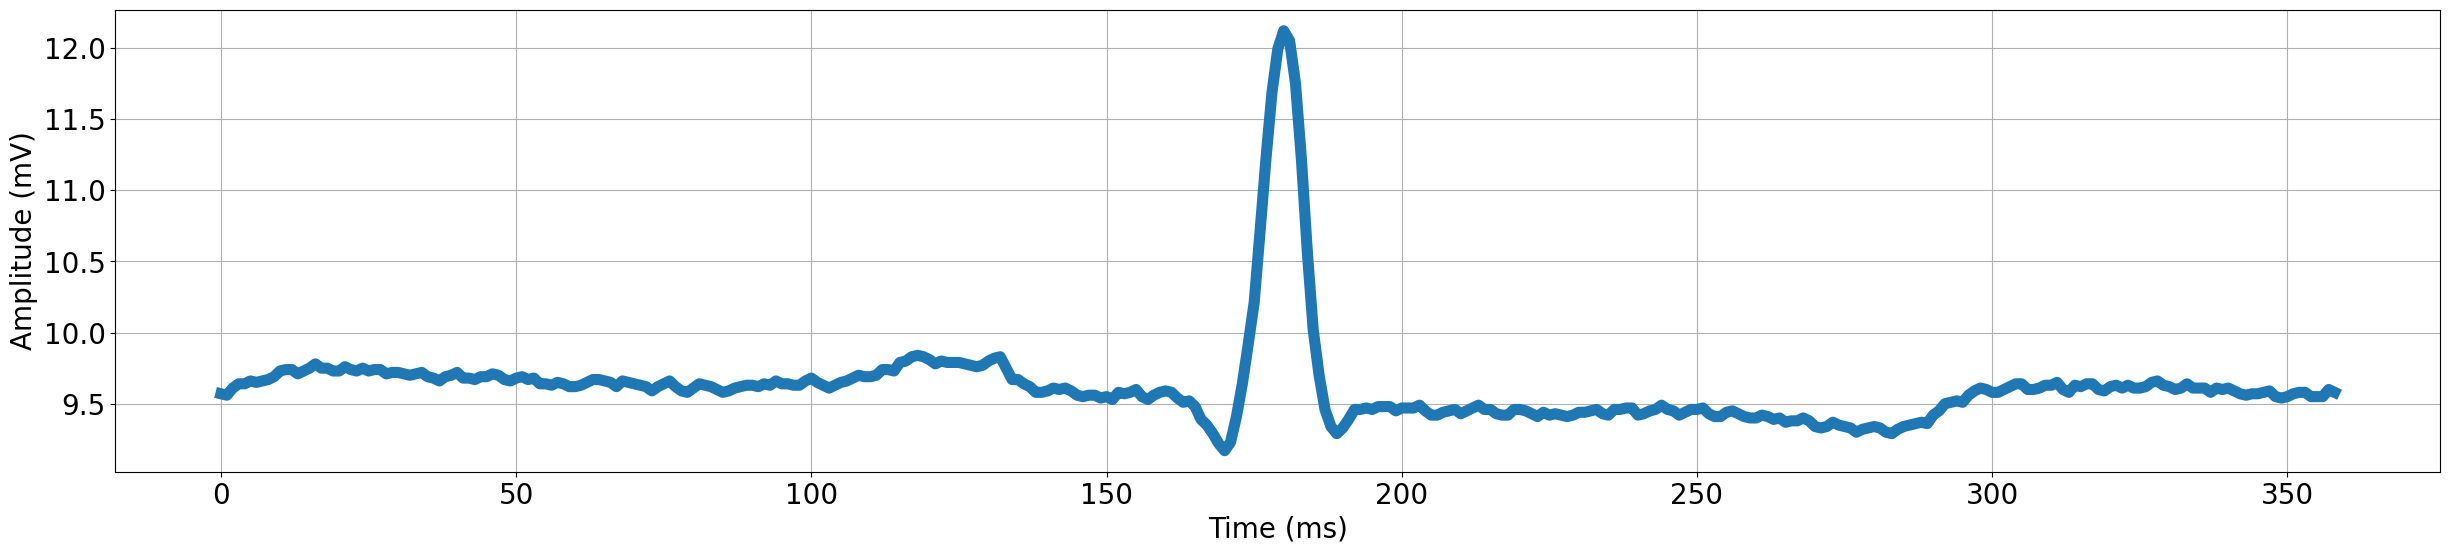

In [11]:
#print an example beat in mV
ex = X_df/100
ex.iloc[0,0:359].plot(linewidth=8)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (mV)')

0    75011
1     8071
2     7255
4     7129
3     2546
Name: 360, dtype: int64


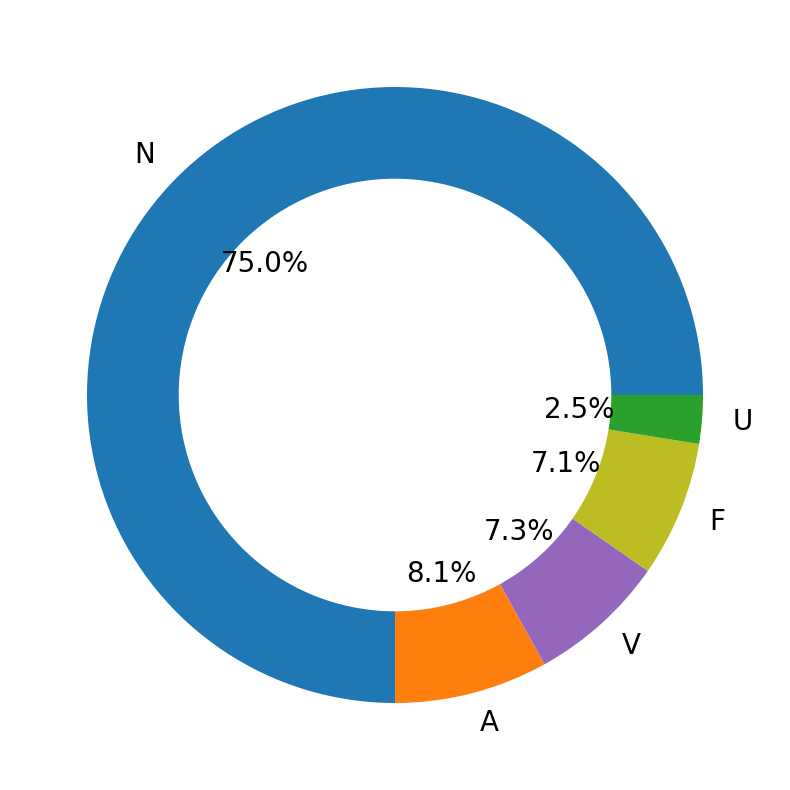

In [12]:
#data distribution before resampling
per_class = X_df[X_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(30,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'A', 'V', 'F', 'U'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [31]:
feat_table = pd.DataFrame()

feat_table['beat_avg'] = X_df.mean(axis=1)
feat_table['beat_std'] = X_df.std(axis=1)
feat_table['beat_max'] = X_df.max(axis=1)
feat_table['beat_min'] = X_df.min(axis=1)
feat_table['beat_range'] = feat_table['beat_max'] - feat_table['beat_min']
feat_table['beat_ratio'] = feat_table['beat_min']/feat_table['beat_max']

#features by each quarter of beat
feat_table['qtr1_avg'] = X_df.iloc[:,0:90].mean(axis=1)
feat_table['qtr1_std'] = X_df.iloc[:,0:90].std(axis=1)
feat_table['qtr1_max'] = X_df.iloc[:,0:90].max(axis=1)
feat_table['qtr1_min'] = X_df.iloc[:,0:90].min(axis=1)
feat_table['qtr1_var'] = X_df.iloc[:,0:90].var(axis=1)

feat_table['qtr2_avg'] = X_df.iloc[:,91:179].mean(axis=1)
feat_table['qtr2_std'] = X_df.iloc[:,91:179].std(axis=1)
feat_table['qtr2_max'] = X_df.iloc[:,91:179].max(axis=1)
feat_table['qtr2_min'] = X_df.iloc[:,91:179].min(axis=1)
feat_table['qtr2_var'] = X_df.iloc[:,91:179].var(axis=1)

feat_table['qtr3_avg'] = X_df.iloc[:,180:269].mean(axis=1)
feat_table['qtr3_std'] = X_df.iloc[:,180:269].std(axis=1)
feat_table['qtr3_max'] = X_df.iloc[:,180:269].max(axis=1)
feat_table['qtr3_min'] = X_df.iloc[:,180:269].min(axis=1)
feat_table['qtr3_var'] = X_df.iloc[:,180:269].var(axis=1)

feat_table['qtr4_avg'] = X_df.iloc[:,270:359].mean(axis=1)
feat_table['qtr4_std'] = X_df.iloc[:,270:359].std(axis=1)
feat_table['qtr4_max'] = X_df.iloc[:,270:359].max(axis=1)
feat_table['qtr4_min'] = X_df.iloc[:,270:359].min(axis=1)
feat_table['qtr4_var'] = X_df.iloc[:,270:359].var(axis=1)

In [13]:
category = X_df[360]
X_df.drop([360], axis=1, inplace=True)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(feat_table,category,test_size=0.3,stratify = category)

In [33]:

#convert the y data sets from vectors to matrix
oc_y_test = (np.where(y_test == 0, 1, -1))
oc_y_train = (np.where(y_train == 0, 1, -1))

In [34]:
X_train['cat'] = y_train

In [35]:
class0 = X_train.loc[X_train['cat']==0]

In [37]:
np.unique(oc_y_test, return_counts=True)

(array([-1,  1]), array([ 7500, 22504]))

In [55]:
class0

,beat_avg,beat_std,beat_max,beat_min,beat_range,beat_ratio,qtr1_avg,qtr1_std,qtr1_max,qtr1_min,...,qtr3_avg,qtr3_std,qtr3_max,qtr3_min,qtr3_var,qtr4_avg,qtr4_std,qtr4_max,qtr4_min,qtr4_var
84139,913.519444,71.400082,1307,848,459,0.648814,906.288889,12.560187,920,868,...,905.280899,107.547346,1307,852,11566.431563,892.235955,17.307396,908,848,299.545965
85240,940.525000,74.106484,1382,869,513,0.628799,919.377778,24.578961,944,869,...,933.191011,113.087645,1382,880,12788.815373,937.516854,8.193834,951,909,67.138917
36076,852.266667,58.874930,1190,787,403,0.661345,842.444444,9.190996,858,825,...,859.696629,90.535453,1190,811,8196.668284,841.179775,8.612309,861,827,74.171859
87812,994.069444,33.034517,1159,932,227,0.804142,973.155556,6.624624,988,956,...,1019.449438,33.426314,1159,984,1117.318437,1008.898876,23.625893,1049,970,558.182840
24357,933.408333,60.624994,1385,733,652,0.529242,931.688889,14.868445,982,919,...,938.842697,102.432006,1385,733,10492.315884,930.000000,23.932196,961,894,572.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79038,912.925000,64.329604,1359,671,688,0.493745,902.688889,9.676387,924,886,...,922.595506,110.387820,1359,671,12185.470889,921.573034,40.022405,999,881,1601.792901
68277,1024.963889,94.213775,1490,809,681,0.542953,1075.555556,76.810742,1180,963,...,981.056180,134.793812,1490,809,18169.371808,1016.550562,39.081212,1099,971,1527.341164
59195,1000.952778,40.381958,1279,867,412,0.677873,1014.233333,25.521549,1059,978,...,1006.000000,65.719964,1279,867,4319.113636,983.494382,9.578769,1006,961,91.752809
63344,999.950000,43.152741,1251,957,294,0.764988,997.122222,9.887943,1015,975,...,992.910112,64.804714,1251,957,4199.650919,986.685393,5.037576,996,974,25.377171


In [56]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(class0)
class0_scaled = scaler.transform(class0)
scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)

In [57]:
one_class = svm.OneClassSVM(gamma='auto', kernel='rbf', nu=0.5)
one_class.fit(class0)

OneClassSVM(gamma='auto')

In [58]:
one_class_pred = one_class.predict(X_test)

/opt/anaconda3/envs/ds/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ds/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ds/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          -1       0.25      1.00      0.40      7500
           1       0.00      0.00      0.00     22504

    accuracy                           0.25     30004
   macro avg       0.12      0.50      0.20     30004
weighted avg       0.06      0.25      0.10     30004



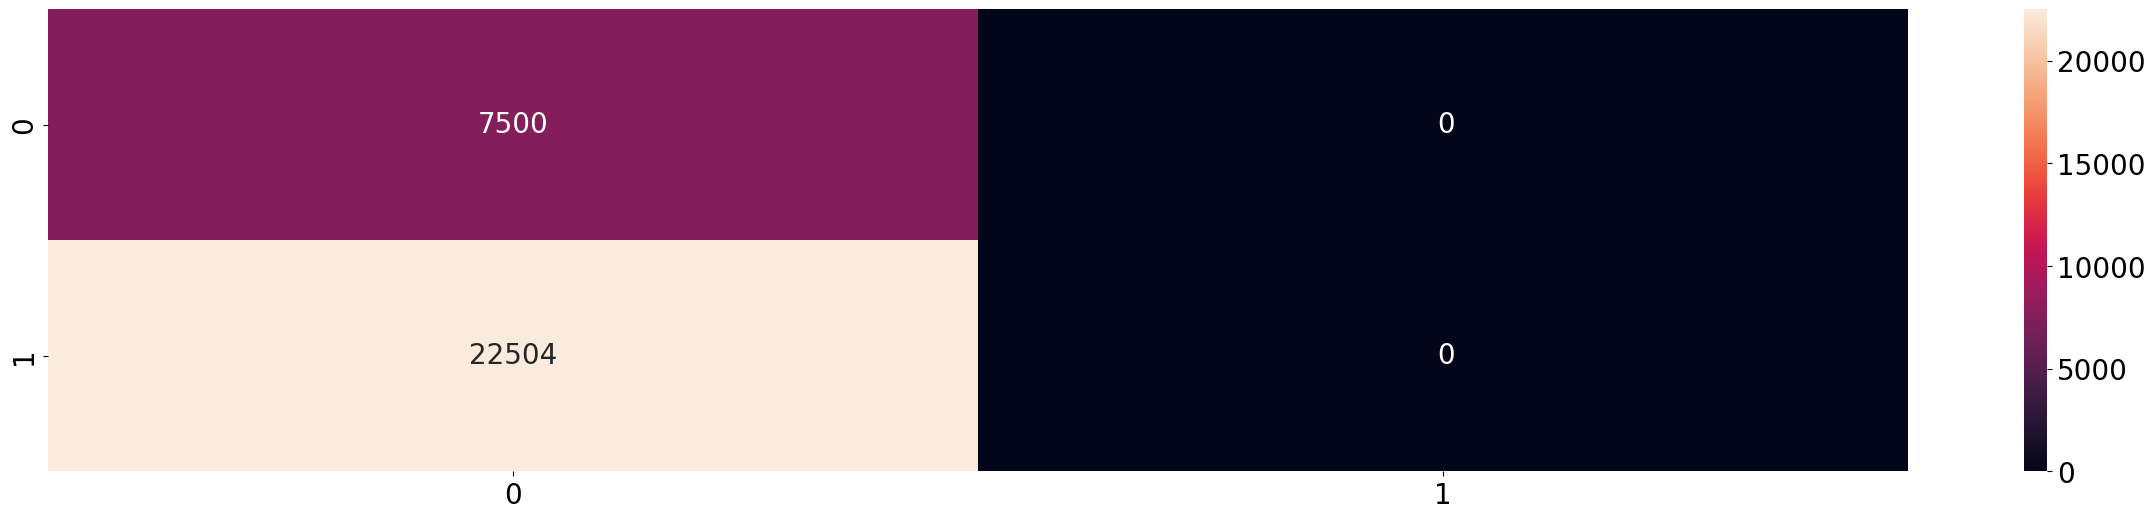

In [59]:
print(classification_report(oc_y_test, one_class_pred))
sns.heatmap(confusion_matrix(oc_y_test, one_class_pred),annot=True,fmt='2.0f')
plt.show()

In [51]:
np.unique(one_class_pred, return_counts=True)

(array([-1]), array([30004]))

In [40]:
y_test.value_counts()

0    22504
1     2421
2     2176
4     2139
3      764
Name: 360, dtype: int64

In [42]:
np.unique((np.where(y_test == 0, 1, -1)), return_counts=True)

(array([-1,  1]), array([ 7500, 22504]))

In [44]:
X_test

,beat_avg,beat_std,beat_max,beat_min,beat_range,beat_ratio,qtr1_avg,qtr1_std,qtr1_max,qtr1_min,...,qtr3_avg,qtr3_std,qtr3_max,qtr3_min,qtr3_var,qtr4_avg,qtr4_std,qtr4_max,qtr4_min,qtr4_var
11624,960.269444,46.099833,1171,870,301,0.742955,962.355556,2.745010,967,955,...,936.595506,64.761577,1171,870,4194.061798,952.764045,9.696558,966,929,94.023238
58609,998.575000,37.383430,1230,882,348,0.717073,1000.244444,26.618955,1051,973,...,1007.977528,59.492356,1230,882,3539.340398,994.707865,9.260378,1029,980,85.754597
65903,971.611111,45.928173,1318,932,386,0.707132,969.522222,23.149843,1009,937,...,989.808989,66.523044,1318,932,4425.315373,958.258427,7.714402,986,947,59.512002
48705,974.838889,56.213497,1196,889,307,0.743311,983.055556,83.561101,1196,892,...,975.011236,52.713741,1145,903,2778.738509,961.382022,19.126674,1024,910,365.829673
68943,945.291667,99.989280,1437,798,639,0.555324,908.977778,85.373071,1044,820,...,915.011236,126.970603,1430,798,16121.533963,994.067416,44.649086,1071,934,1993.540858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38786,847.302778,55.775465,1218,670,548,0.550082,827.344444,3.208700,834,821,...,841.191011,86.508522,1218,670,7483.724464,868.303371,21.579875,912,843,465.691011
15232,978.108333,143.717891,1555,777,778,0.499678,969.155556,55.910022,1027,839,...,912.876404,197.181839,1535,777,38880.677732,984.337079,36.343983,1024,874,1320.885087
49392,1040.230556,59.487127,1250,920,330,0.736000,1074.700000,26.128227,1112,1020,...,1025.348315,68.686889,1250,920,4717.888662,1010.898876,67.301061,1214,925,4529.432840
69574,1014.050000,71.665369,1442,934,508,0.647712,1006.411111,12.252855,1021,964,...,1012.977528,116.227244,1442,934,13508.772217,1002.168539,15.820180,1017,952,250.278090


In [ ]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size